In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import keras
import sys
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

# Data Cleaning

In [31]:
# import data from CSV file
raw_data = pd.read_csv('NFLCombineData.csv')
print(raw_data.shape)

(4945, 25)


In [32]:
# quick test, to see how many values are missing for a specific parameter
parameter = 'fortyyd'
raw_data_no_outlier = raw_data.loc[raw_data[parameter] > 0]
print("Number of Players' Data Missing for -->", "\b", parameter, ":", raw_data.shape[0]-raw_data_no_outlier.shape[0])

Number of Players' Data Missing for -->  fortyyd : 191


In [33]:
# combining positions based on related characterisitcs into groupings (6 classes)
    # 0: Running Backs: RB, FB
    # 1: Pass Catchers: WR, TE
    # 2: Defensive Backs: FS, SS, CB
    # 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
    # 4: Linebackers: ILB, OLB
    # 5: Quarterback + Special Team: QB, P, K
    
# create dictionary of metrics corresponding to index in data
pos_dict = {'year': 0, 'name': 1, 'firstname': 2, 'lastname': 3, 'position': 4, 'heightfeet': 5, 
            'heightinches': 6, 'heightinchestotal': 7, 'weight': 8, 'arms': 9, 'hands': 10,
            'fortyyd': 11, 'twentyyd': 12, 'tenyd': 13, 'twentyss': 14, 'threecone': 15, 
            'vertical': 16, 'broad': 17, 'bench': 18, 'round': 19, 'college': 20, 
            'pickround': 21, 'picktotal': 22, 'wonderlic': 23, 'nflgrade': 24}

# extract all players (stored by position) from raw_data
rb = (raw_data.loc[raw_data['position'] == 'RB']).to_numpy()
fb = (raw_data.loc[raw_data['position'] == 'FB']).to_numpy()
wr = (raw_data.loc[raw_data['position'] == 'WR']).to_numpy()
te = (raw_data.loc[raw_data['position'] == 'TE']).to_numpy()
fs = (raw_data.loc[raw_data['position'] == 'FS']).to_numpy()
ss = (raw_data.loc[raw_data['position'] == 'SS']).to_numpy()
cb = (raw_data.loc[raw_data['position'] == 'CB']).to_numpy()
ot = (raw_data.loc[raw_data['position'] == 'OT']).to_numpy()
og = (raw_data.loc[raw_data['position'] == 'OG']).to_numpy()
oc = (raw_data.loc[raw_data['position'] == 'OC']).to_numpy()
c = (raw_data.loc[raw_data['position'] == 'C']).to_numpy()
nt = (raw_data.loc[raw_data['position'] == 'NT']).to_numpy()
dt = (raw_data.loc[raw_data['position'] == 'DT']).to_numpy()
de = (raw_data.loc[raw_data['position'] == 'DE']).to_numpy()
ls = (raw_data.loc[raw_data['position'] == 'LS']).to_numpy()
ilb = (raw_data.loc[raw_data['position'] == 'ILB']).to_numpy()
olb = (raw_data.loc[raw_data['position'] == 'OLB']).to_numpy()
qb = (raw_data.loc[raw_data['position'] == 'QB']).to_numpy()
p = (raw_data.loc[raw_data['position'] == 'P']).to_numpy()
k = (raw_data.loc[raw_data['position'] == 'K']).to_numpy()

# concatenate similar positions based on the classification of groups (detailed above)
run_back = np.concatenate((rb, fb))
print(len(run_back))
pass_catch = np.concatenate((wr, te))
print(len(pass_catch))
defense_back = np.concatenate((fs, ss, cb))
print(len(defense_back))
linemen = np.concatenate((ot, og, oc, c, nt, dt, de, ls))
print(len(linemen))
lineback = np.concatenate((ilb, olb))
print(len(lineback))
quarterback_special = np.concatenate((qb, p, k))
print(len(quarterback_special))

557
922
885
1668
588
325


# Basic Preprocessing (no normalization or zero-meaning)

In [34]:
# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['weight', 'heightinchestotal', 'broad', 'fortyyd', 'bench']

#####################################################################################

def simple_preprocess_data(position, index):
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            rowArr.append(stat)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        
        
# 0: Running Backs: RB, FB
simple_preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
simple_preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
simple_preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
simple_preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
simple_preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
simple_preprocess_data(quarterback_special, 5)
    
c = list(zip(data_players, pos_index))

random.shuffle(c)

data_players, pos_index = zip(*c)

data_players = np.array(data_players)
pos_index = np.array(pos_index)
pos_cat = to_categorical(pos_index, 6)
print(data_players)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled

# ALL GOOD SO FAR

[[207.     73.      0.      4.5    16.   ]
 [208.     69.    113.      4.4    18.   ]
 [306.     79.    116.      5.05   27.   ]
 [316.     75.     94.      5.43   24.   ]
 [203.     74.    112.      4.78    0.   ]
 [177.     71.    126.      4.39    0.   ]
 [221.     73.    124.      4.53    0.   ]
 [231.     73.    117.      5.     15.   ]
 [295.     74.      0.      5.29    0.   ]
 [202.     73.    123.      4.45   14.   ]
 [202.     73.    113.      4.51   17.   ]
 [188.     73.    115.      4.84    0.   ]
 [279.     79.    106.      4.9    20.   ]
 [233.     75.    109.      0.      0.   ]
 [214.     73.    133.      4.44   17.   ]
 [301.     77.    108.      5.33   21.   ]
 [219.     73.    111.      4.68   16.   ]
 [213.     69.    112.      4.58   22.   ]
 [201.     69.    130.      4.48   20.   ]
 [188.     70.    124.      4.63   14.   ]
 [217.     74.    123.      4.54    9.   ]
 [318.     77.    108.      5.39   26.   ]
 [229.     76.    130.      4.51    0.   ]
 [284.     

In [35]:

model = keras.Sequential()
model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#odel.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Simple data -> Softmax model

In [36]:
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 42us/step - loss: 103.7361 - accuracy: 0.2649 - val_loss: 77.8092 - val_accuracy: 0.3407
Epoch 2/100
3956/3956 [==============================] - 0s 24us/step - loss: 67.4705 - accuracy: 0.3880 - val_loss: 53.3511 - val_accuracy: 0.3903
Epoch 3/100
3956/3956 [==============================] - 0s 22us/step - loss: 43.3818 - accuracy: 0.4120 - val_loss: 29.2549 - val_accuracy: 0.4004
Epoch 4/100
3956/3956 [==============================] - 0s 23us/step - loss: 23.0551 - accuracy: 0.4899 - val_loss: 16.3814 - val_accuracy: 0.4944
Epoch 5/100
3956/3956 [==============================] - 0s 23us/step - loss: 14.4571 - accuracy: 0.5013 - val_loss: 10.3580 - val_accuracy: 0.4924
Epoch 6/100
3956/3956 [==============================] - 0s 24us/step - loss: 9.6909 - accuracy: 0.5159 - val_loss: 8.5782 - val_accuracy: 0.5308
Epoch 7/100
3956/3956 [==============================] - 0s 23us/s

3956/3956 [==============================] - 0s 22us/step - loss: 0.9090 - accuracy: 0.6105 - val_loss: 0.9752 - val_accuracy: 0.5875
Epoch 57/100
3956/3956 [==============================] - 0s 24us/step - loss: 0.9215 - accuracy: 0.5998 - val_loss: 1.0202 - val_accuracy: 0.5774
Epoch 58/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.9083 - accuracy: 0.6117 - val_loss: 0.9922 - val_accuracy: 0.5915
Epoch 59/100
3956/3956 [==============================] - 0s 23us/step - loss: 0.9090 - accuracy: 0.6120 - val_loss: 0.9958 - val_accuracy: 0.5966
Epoch 60/100
3956/3956 [==============================] - 0s 24us/step - loss: 0.9147 - accuracy: 0.6029 - val_loss: 0.9916 - val_accuracy: 0.5834
Epoch 61/100
3956/3956 [==============================] - 0s 23us/step - loss: 0.9056 - accuracy: 0.6127 - val_loss: 0.9850 - val_accuracy: 0.6006
Epoch 62/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.9113 - accuracy: 0.6095 - val_loss: 0.9805 - val_a

Text(0.5, 1.0, 'accuracy')

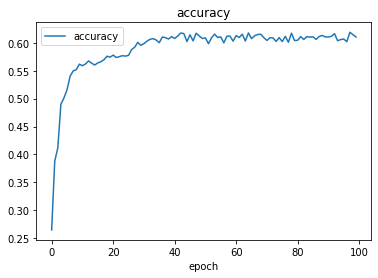

In [37]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

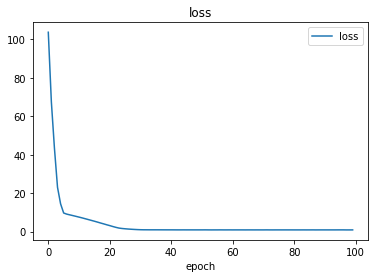

In [38]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

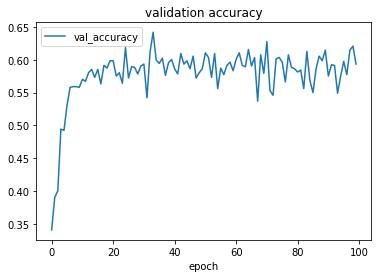

In [39]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [40]:
#Very low to begin with and decreases over time

Text(0.5, 1.0, 'validation loss')

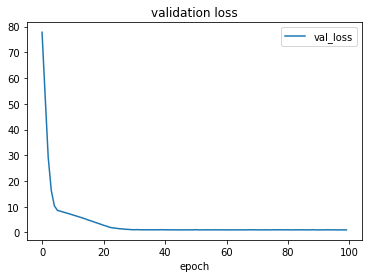

In [41]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

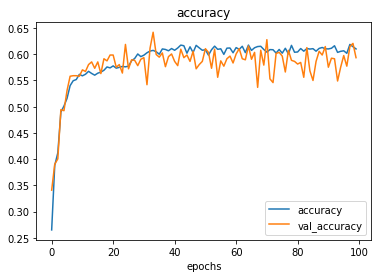

In [42]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [43]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [2 2 3 3 1 2 1 4 3 2 2 2 3 1 2 3 2 2 2 2 1 3 1 3 2 2 4 3 2 4 1 4 2 4 4 3 4
 4 1 3 2 4 1 3 3 3 2 1 3 4 3 1 3 2 2 3 2 3 4 1 3 2 3 3 3 3 3 2 2 2 3 2 2 4
 2 2 3 2 4 4 4 2 4 1 3 4 4 1 1 3 4 2 3 2 4 2 1 3 3 2 2 1 2 1 3 1 4 3 1 1 3
 3 4 2 2 2 1 3 3 4 2 3 2 4 0 4 1 4 3 2 2 1 4 4 3 3 4 1 2 4 3 2 1 2 4 2 4 0
 2 4 2 4 2 3 4 3 4 4 4 2 5 4 3 2 3 1 3 2 3 4 5 0 4 2 2 2 1 4 1 3 2 4 2 4 3
 2 3 3 1 4 3 3 3 1 2 2 2 2 1 2 4 3 2 2 3 3 2 3 2 4 3 3 3 3 4 3 2 3 2 3 3 2
 2 2 3 2 4 3 1 1 3 1 1 3 3 1 1 3 3 4 2 4 2 1 3 3 1 3 4 4 0 4 1 2 2 4 2 1 4
 4 5 2 4 2 1 4 3 4 3 2 3 3 2 2 2 2 1 2 1 1 5 3 4 3 2 3 2 4 4 4 2 2 2 2 3 3
 5 4 1 1 3 2 4 2 2 3 3 2 1 2 2 3 3 3 2 2 3 4 4 3 4 2 3 2 3 1 2 4 1 2 2 2 4
 4 4 2 2 1 2 3 1 3 3 3 1 2 4 3 1 2 4 4 3 3 2 2 1 3 3 0 4 2 3 4 4 3 3 1 3 2
 3 1 2 2 4 3 4 3 5 4 3 1 3 1 3 2 1 4 3 4 3 3 2 1 2 3 4 3 4 2 1 1 2 1 4 1 3
 1 1 3 4 2 1 2 2 1 1 3 3 2 4 4 2 3 3 2 4 2 2 4 1 3 1 4 4 2 4 3 4 1 2 3 1 2
 2 1 3 4 2 4 3 3 4 4 1 4 2 4 0 1 2 1 1 3 3 1 4 1 2 1 1 2 2 4 2 4 2 2 1 2 4
 1 3 1

# Simple Data -> ReLU + Softmax model

In [45]:
#TRYING DIFFERENT MODEL

In [46]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 50us/step - loss: 9.9665 - accuracy: 0.3294 - val_loss: 1.7693 - val_accuracy: 0.4176
Epoch 2/100
3956/3956 [==============================] - 0s 26us/step - loss: 1.4130 - accuracy: 0.4464 - val_loss: 1.3717 - val_accuracy: 0.4439
Epoch 3/100
3956/3956 [==============================] - 0s 24us/step - loss: 1.2437 - accuracy: 0.4836 - val_loss: 1.2262 - val_accuracy: 0.5157
Epoch 4/100
3956/3956 [==============================] - 0s 27us/step - loss: 1.1578 - accuracy: 0.5286 - val_loss: 1.1482 - val_accuracy: 0.5187
Epoch 5/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.1133 - accuracy: 0.5296 - val_loss: 1.1276 - val_accuracy: 0.5197
Epoch 6/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.0640 - accuracy: 0.5412 - val_loss: 1.0931 - val_accuracy: 0.5147
Epoch 7/100
3956/3956 [==============================] - 0s 25us/step - loss:

3956/3956 [==============================] - 0s 25us/step - loss: 0.9854 - accuracy: 0.5667 - val_loss: 1.0994 - val_accuracy: 0.5137
Epoch 57/100
3956/3956 [==============================] - 0s 26us/step - loss: 0.9932 - accuracy: 0.5614 - val_loss: 1.0474 - val_accuracy: 0.5187
Epoch 58/100
3956/3956 [==============================] - 0s 28us/step - loss: 0.9890 - accuracy: 0.5645 - val_loss: 1.0398 - val_accuracy: 0.5308
Epoch 59/100
3956/3956 [==============================] - 0s 25us/step - loss: 0.9851 - accuracy: 0.5667 - val_loss: 1.0504 - val_accuracy: 0.5076
Epoch 60/100
3956/3956 [==============================] - 0s 27us/step - loss: 0.9869 - accuracy: 0.5627 - val_loss: 1.0438 - val_accuracy: 0.5531
Epoch 61/100
3956/3956 [==============================] - 0s 25us/step - loss: 0.9808 - accuracy: 0.5660 - val_loss: 1.0772 - val_accuracy: 0.4965
Epoch 62/100
3956/3956 [==============================] - 0s 24us/step - loss: 0.9930 - accuracy: 0.5574 - val_loss: 1.0586 - val_a

In [47]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

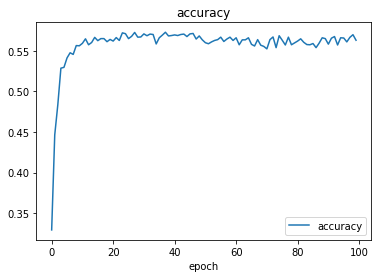

In [48]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

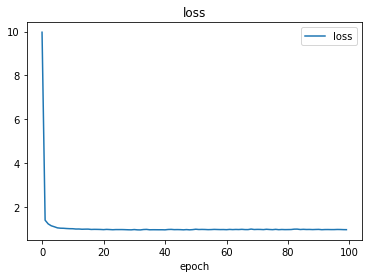

In [49]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

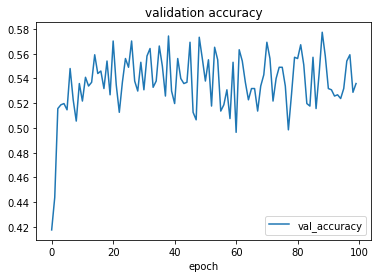

In [50]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [51]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

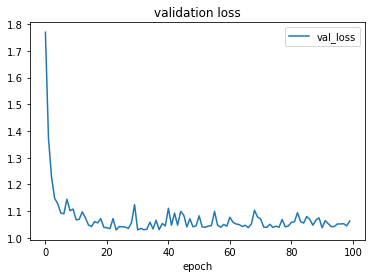

In [52]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

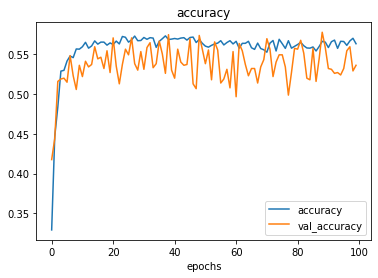

In [56]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [54]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [2 1 3 3 2 2 1 0 3 2 2 2 3 1 2 3 1 1 2 2 2 3 1 3 2 2 4 3 2 4 1 4 2 4 4 3 4
 4 1 3 2 4 1 3 3 3 2 1 3 0 3 1 3 2 1 3 2 3 4 0 3 2 3 3 3 3 3 2 2 2 3 2 2 4
 2 2 3 2 0 4 4 2 4 2 3 4 4 2 0 3 0 2 3 2 0 2 2 3 3 2 2 1 2 1 3 1 4 3 0 1 3
 3 0 2 2 2 2 3 3 4 2 3 2 4 1 4 2 4 3 1 2 2 0 0 3 3 0 1 0 0 3 2 1 2 0 1 4 1
 2 0 2 0 2 3 4 3 4 4 0 2 4 4 3 2 3 1 3 2 3 4 4 1 0 1 2 2 2 4 1 3 2 4 2 4 3
 2 3 3 2 4 3 3 3 0 2 2 1 2 1 2 4 4 1 2 3 3 2 3 2 0 3 3 3 3 4 3 2 3 2 3 3 1
 2 2 3 2 4 4 2 2 3 1 1 3 3 2 0 3 3 0 1 0 2 1 3 3 2 3 4 4 0 4 2 1 2 4 2 2 4
 0 0 2 0 2 2 4 3 4 3 2 3 3 2 2 2 2 0 2 0 0 2 3 4 3 2 4 2 4 0 0 1 2 1 2 3 3
 0 4 2 2 3 2 0 2 2 3 3 2 2 1 2 3 3 3 2 2 4 0 4 3 4 2 3 2 3 2 2 4 2 2 2 2 0
 0 0 1 1 1 2 3 2 3 3 3 0 2 0 3 1 2 0 4 3 3 2 2 0 3 3 0 4 2 3 0 0 3 3 1 3 2
 3 0 2 2 4 3 0 3 1 4 3 2 3 2 3 2 2 0 3 4 3 3 1 1 2 3 4 3 0 2 2 0 2 0 0 1 3
 2 2 3 0 2 2 2 2 1 2 3 3 2 0 0 2 3 3 2 0 2 1 0 2 3 2 4 4 2 4 3 0 2 2 3 0 2
 2 2 3 0 2 0 3 3 4 0 0 4 2 4 1 1 2 1 2 3 3 2 0 1 2 1 1 2 2 0 2 4 2 2 1 2 0
 2 3 2

# Zero-meaning and normalizing data for a select few combine events

In [58]:
#This time zero-meaning and normalizing player vectors

# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['weight', 'heightinchestotal', 'broad', 'fortyyd', 'bench']

#####################################################################################

def preprocess_data(position, index): #One of the concatenated numpy arrays defined above, such as "run_back" or "linemen"
    paramMeans = []
    #computing mean
    for j in range(len(parameters)):
        paramMean = 0
        count = 0
        for i in range(len(position)):
            stat = position[i][pos_dict.get(parameters[j])]
            paramMean += stat
            if (stat != 0):
                count += 1
        paramMeans.append(paramMean / count)
            
    #organizing data
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            #filling in zeroes
            if (stat != 0):
                #demeaning
                rowArr.append(stat - paramMeans[j])
            else:
                rowArr.append(paramMeans[j])
        #normalization
        rowArr = rowArr / np.linalg.norm(rowArr)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        

# 0: Running Backs: RB, FB
preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
preprocess_data(quarterback_special, 5)

c = list(zip(data_players, pos_index))

random.shuffle(c)

data_players, pos_index = zip(*c)

data_players = np.array(data_players)
pos_index = np.array(pos_index)
pos_cat = to_categorical(pos_index, 6)
print(data_players)


# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled
# ALL GOOD SO FAR

[[ 6.92979203e-01 -2.14806414e-02 -2.36658710e-01  3.56639643e-02
   6.79734612e-01]
 [ 2.48903958e-02  3.47198736e-02 -8.77205288e-02 -5.19922169e-03
   9.95215090e-01]
 [ 2.34548127e-01 -1.01803354e-02  9.62871334e-01  9.80150098e-04
   1.33271794e-01]
 [-7.54955876e-01 -2.71302121e-03  2.34889152e-01 -8.25316373e-03
   6.12203591e-01]
 [ 8.25670172e-01  1.56157962e-02 -4.39420205e-01  1.58747728e-02
  -3.53104502e-01]
 [ 9.32598090e-01  2.74135462e-02 -2.70049010e-01  4.33328904e-03
   2.37831989e-01]
 [-7.65313341e-01  1.54154387e-01  4.45656734e-01 -1.66951197e-02
  -4.37770789e-01]
 [-9.60229725e-01 -6.55624670e-02  1.59890964e-01 -4.20025777e-03
  -2.19266220e-01]
 [-9.93442308e-01 -2.91864721e-03  7.14253093e-02 -7.58392806e-03
  -8.89087869e-02]
 [ 9.65945106e-01  3.77632236e-02  2.55615885e-01 -3.63430091e-03
   1.30882191e-02]
 [ 2.65581808e-02  6.65674610e-03 -5.38510396e-01  2.39954225e-02
   8.41832005e-01]
 [-9.69824109e-01 -1.59077591e-01  2.02977103e-02 -1.25884838e-03

# Fancy data -> ReLu + Softmax model

In [59]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 51us/step - loss: 1.6630 - accuracy: 0.3246 - val_loss: 1.6123 - val_accuracy: 0.3367
Epoch 2/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.5985 - accuracy: 0.3375 - val_loss: 1.5837 - val_accuracy: 0.3397
Epoch 3/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.5746 - accuracy: 0.3602 - val_loss: 1.5578 - val_accuracy: 0.3660
Epoch 4/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.5612 - accuracy: 0.3857 - val_loss: 1.5526 - val_accuracy: 0.3792
Epoch 5/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.5502 - accuracy: 0.3903 - val_loss: 1.5478 - val_accuracy: 0.3883
Epoch 6/100
3956/3956 [==============================] - 0s 26us/step - loss: 1.5437 - accuracy: 0.3908 - val_loss: 1.5428 - val_accuracy: 0.3842
Epoch 7/100
3956/3956 [==============================] - 0s 25us/step - loss:

3956/3956 [==============================] - 0s 26us/step - loss: 1.4852 - accuracy: 0.4133 - val_loss: 1.4984 - val_accuracy: 0.4095
Epoch 57/100
3956/3956 [==============================] - 0s 27us/step - loss: 1.4814 - accuracy: 0.4143 - val_loss: 1.4998 - val_accuracy: 0.4216
Epoch 58/100
3956/3956 [==============================] - 0s 27us/step - loss: 1.4850 - accuracy: 0.4118 - val_loss: 1.4903 - val_accuracy: 0.4237
Epoch 59/100
3956/3956 [==============================] - 0s 27us/step - loss: 1.4828 - accuracy: 0.4156 - val_loss: 1.4903 - val_accuracy: 0.4237
Epoch 60/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.4819 - accuracy: 0.4158 - val_loss: 1.4987 - val_accuracy: 0.4095
Epoch 61/100
3956/3956 [==============================] - 0s 28us/step - loss: 1.4835 - accuracy: 0.4115 - val_loss: 1.4955 - val_accuracy: 0.4186
Epoch 62/100
3956/3956 [==============================] - 0s 24us/step - loss: 1.4851 - accuracy: 0.4156 - val_loss: 1.4965 - val_a

In [60]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

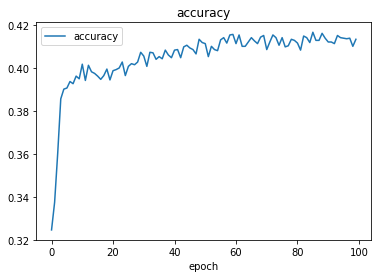

In [61]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

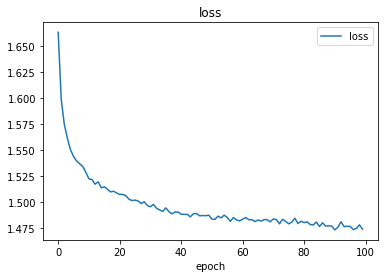

In [62]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

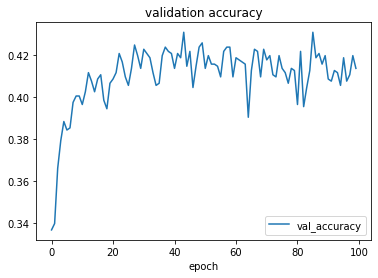

In [63]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [64]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

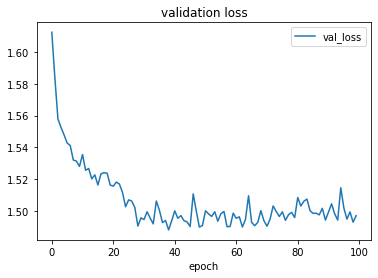

In [65]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

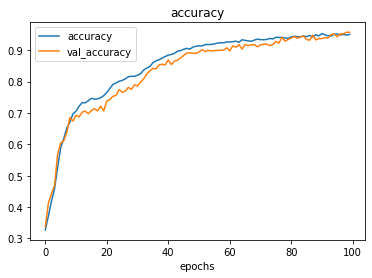

In [80]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [67]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [3 5 3 1 3 3 3 1 3 1 5 1 3 1 3 3 3 2 2 3 3 1 1 3 2 5 1 1 3 3 3 3 5 3 3 3 1
 2 3 3 1 1 2 1 3 3 3 2 5 1 3 3 1 3 3 1 2 1 1 2 1 2 1 3 1 1 3 3 3 2 3 1 1 1
 3 3 3 1 1 1 5 3 3 3 1 3 3 3 3 3 3 3 1 1 3 1 1 1 3 3 3 3 1 3 3 3 1 1 1 2 3
 3 1 3 3 5 1 1 1 1 3 1 3 3 3 3 3 3 5 1 3 3 1 3 3 3 3 1 1 1 1 3 1 3 3 2 5 1
 3 2 3 3 1 5 1 3 3 3 1 1 3 3 3 3 3 1 3 3 1 1 1 1 3 3 1 5 3 1 3 3 3 3 3 3 2
 3 1 1 1 5 3 5 1 1 1 1 3 3 2 3 1 3 3 3 2 3 1 2 1 3 5 1 1 3 5 5 3 3 1 1 1 5
 3 5 3 1 3 1 3 3 3 1 2 2 3 5 3 1 1 3 5 3 1 3 3 5 3 5 3 3 1 2 1 3 3 3 1 3 3
 5 5 3 1 1 3 3 5 1 3 3 5 1 3 3 1 3 3 3 3 3 1 3 1 5 3 3 1 3 1 1 3 2 3 3 3 1
 3 5 3 3 3 3 3 3 2 2 1 3 3 1 3 3 3 3 1 3 1 3 2 1 1 3 2 3 1 3 1 1 3 1 2 1 3
 1 1 5 3 3 3 5 5 3 3 2 3 3 5 1 3 3 5 5 2 1 3 3 1 1 1 3 3 3 3 5 1 3 3 1 1 3
 2 3 3 5 3 3 1 1 1 3 1 1 1 3 1 2 1 5 1 3 1 1 2 2 1 2 3 3 3 1 1 1 3 3 1 3 2
 1 1 3 3 3 2 3 3 3 3 1 3 3 5 1 3 2 3 3 3 1 1 3 3 3 1 1 3 1 3 3 3 2 3 5 1 3
 3 1 3 2 1 3 2 1 1 3 1 3 1 1 3 2 3 3 2 3 1 2 1 3 1 3 3 3 3 3 5 1 3 1 3 1 3
 3 3 3

In [68]:
#Again no 4s or 5s

# Zero-meaning and normalizing data for all combine events

In [213]:
#Trying all parameters!

# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['year', 'heightfeet', 
            'heightinches', 'heightinchestotal', 'weight', 'arms', 'hands',
            'fortyyd', 'twentyyd', 'tenyd', 'twentyss', 'threecone', 
            'vertical', 'broad', 'bench', 'round', 
            'pickround', 'picktotal', 'wonderlic', 'nflgrade'] #all strings removed

parametersnew = ['year', 'heightinchestotal', 'weight', 'arms', 'hands',
            'fortyyd', 'twentyyd', 'tenyd', 'twentyss', 'threecone', 
            'vertical', 'broad', 'bench', 'round', 
            'pickround', 'picktotal', 'wonderlic','nflgrade']


#####################################################################################

def preprocess_data(position, index): #One of the concatenated numpy arrays defined above, such as "run_back" or "linemen"
    paramMeans = []
    #computing mean
    for j in range(len(parameters)):
        paramMean = 0
        count = 0
        for i in range(len(position)):
            stat = position[i][pos_dict.get(parameters[j])]
            paramMean += stat
            if (stat != 0):
                count += 1
        if (count == 0):   #sometimes there are no parameter stats for a certain position
            paramMeans.append(0)
        else:
            paramMeans.append(paramMean / count)
            
    #organizing data
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            #filling in zeroes
            if (stat != 0):
                #demeaning
                rowArr.append(stat - paramMeans[j])
            else:
                rowArr.append(paramMeans[j])
        #normalization
        rowArr = rowArr / np.linalg.norm(rowArr)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        

# 0: Running Backs: RB, FB
preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
preprocess_data(quarterback_special, 5)

c = list(zip(data_players, pos_index))

random.shuffle(c)

data_players, pos_index = zip(*c)

data_players = np.array(data_players)
pos_index = np.array(pos_index)
data_players_test = data_players[int(round(len(data_players) * 0.9)):]
data_players = data_players[:int(round(len(data_players) * 0.9))]
pos_index_test = pos_index[int(round(len(pos_index) * 0.9)):]
pos_index = pos_index[:int(round(len(pos_index) * 0.9))]
pos_cat = to_categorical(pos_index, 6)
print(data_players)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled
# ALL GOOD SO FAR

[[ 7.24616956e-03 -4.78003622e-03  2.83369376e-02 -2.54643490e-02
  -2.54042180e-01  2.84319263e-01  8.29974775e-02 -1.18948582e-03
   2.34419674e-02  1.37518225e-02  7.69750906e-04  6.23237001e-02
  -1.69493270e-02  6.61203335e-02  2.04138337e-02  2.81362265e-02
  -1.17035704e-01  8.89147526e-01  1.70650338e-01  4.81156967e-02]
 [ 1.29996376e-02  1.51676177e-03  3.53038413e-03  2.28905318e-02
   1.51099148e-01  2.45625490e-01  7.17277878e-02  7.79985622e-04
   1.97471265e-02  1.18404157e-02 -4.68203851e-05  5.28690676e-02
  -9.30036147e-03  2.92516369e-02  1.78658196e-02  3.12322544e-02
   1.45504773e-01  9.31565660e-01  1.21604726e-01  4.05948602e-02]
 [-7.16347164e-02  2.40962525e-04 -2.44793737e-02 -2.07098685e-02
  -9.40442313e-02  3.60965331e-01  1.07826234e-01 -3.86823618e-05
   2.96469964e-02  1.86032905e-02 -1.35373624e-03 -1.72116089e-04
   7.51340715e-03 -5.63986392e-02  2.10589098e-01 -1.98235461e-02
  -1.75075278e-01 -8.71450937e-01  1.87833006e-02  5.86318727e-02]
 [ 1.33

# Rich fancy data -> ReLU + Softmax model

In [214]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=200, batch_size = 100, shuffle=True)

Train on 3560 samples, validate on 890 samples
Epoch 1/200
3560/3560 [==============================] - 0s 38us/step - loss: 1.7103 - accuracy: 0.3169 - val_loss: 1.6647 - val_accuracy: 0.3449
Epoch 2/200
3560/3560 [==============================] - 0s 11us/step - loss: 1.6612 - accuracy: 0.3343 - val_loss: 1.6401 - val_accuracy: 0.3449
Epoch 3/200
3560/3560 [==============================] - 0s 10us/step - loss: 1.6330 - accuracy: 0.3343 - val_loss: 1.6166 - val_accuracy: 0.3449
Epoch 4/200
3560/3560 [==============================] - 0s 9us/step - loss: 1.6021 - accuracy: 0.3390 - val_loss: 1.5776 - val_accuracy: 0.3483
Epoch 5/200
3560/3560 [==============================] - 0s 9us/step - loss: 1.5641 - accuracy: 0.3576 - val_loss: 1.5404 - val_accuracy: 0.3674
Epoch 6/200
3560/3560 [==============================] - 0s 9us/step - loss: 1.5226 - accuracy: 0.3834 - val_loss: 1.5094 - val_accuracy: 0.4000
Epoch 7/200
3560/3560 [==============================] - 0s 10us/step - loss: 1.

3560/3560 [==============================] - 0s 9us/step - loss: 0.4704 - accuracy: 0.8441 - val_loss: 0.4742 - val_accuracy: 0.8382
Epoch 57/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.4683 - accuracy: 0.8399 - val_loss: 0.4744 - val_accuracy: 0.8438
Epoch 58/200
3560/3560 [==============================] - 0s 10us/step - loss: 0.4627 - accuracy: 0.8435 - val_loss: 0.4704 - val_accuracy: 0.8438
Epoch 59/200
3560/3560 [==============================] - 0s 10us/step - loss: 0.4616 - accuracy: 0.8472 - val_loss: 0.4736 - val_accuracy: 0.8393
Epoch 60/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.4593 - accuracy: 0.8455 - val_loss: 0.4651 - val_accuracy: 0.8483
Epoch 61/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.4557 - accuracy: 0.8413 - val_loss: 0.4646 - val_accuracy: 0.8539
Epoch 62/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.4540 - accuracy: 0.8497 - val_loss: 0.4648 - val_accura

Epoch 112/200
3560/3560 [==============================] - 0s 10us/step - loss: 0.3889 - accuracy: 0.8806 - val_loss: 0.4172 - val_accuracy: 0.8685
Epoch 113/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3886 - accuracy: 0.8772 - val_loss: 0.4150 - val_accuracy: 0.8798
Epoch 114/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3855 - accuracy: 0.8815 - val_loss: 0.4111 - val_accuracy: 0.8787
Epoch 115/200
3560/3560 [==============================] - 0s 10us/step - loss: 0.3850 - accuracy: 0.8812 - val_loss: 0.4107 - val_accuracy: 0.8809
Epoch 116/200
3560/3560 [==============================] - 0s 16us/step - loss: 0.3853 - accuracy: 0.8795 - val_loss: 0.4122 - val_accuracy: 0.8787
Epoch 117/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3873 - accuracy: 0.8820 - val_loss: 0.4103 - val_accuracy: 0.8730
Epoch 118/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3842 - accuracy: 0.8820 - val_loss

3560/3560 [==============================] - 0s 10us/step - loss: 0.3519 - accuracy: 0.8907 - val_loss: 0.3871 - val_accuracy: 0.8978
Epoch 168/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3502 - accuracy: 0.8930 - val_loss: 0.3885 - val_accuracy: 0.8888
Epoch 169/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3487 - accuracy: 0.8935 - val_loss: 0.3886 - val_accuracy: 0.8854
Epoch 170/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3477 - accuracy: 0.8949 - val_loss: 0.3838 - val_accuracy: 0.8933
Epoch 171/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3494 - accuracy: 0.8930 - val_loss: 0.3918 - val_accuracy: 0.8843
Epoch 172/200
3560/3560 [==============================] - 0s 9us/step - loss: 0.3489 - accuracy: 0.8927 - val_loss: 0.3883 - val_accuracy: 0.8820
Epoch 173/200
3560/3560 [==============================] - 0s 10us/step - loss: 0.3512 - accuracy: 0.8921 - val_loss: 0.3856 - val_

In [215]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

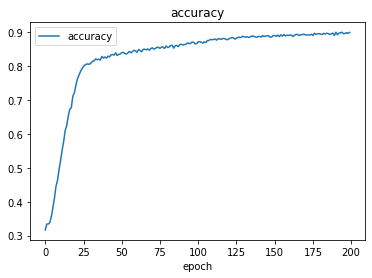

In [216]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

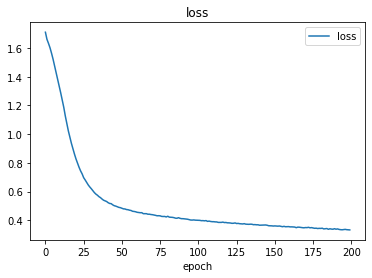

In [217]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

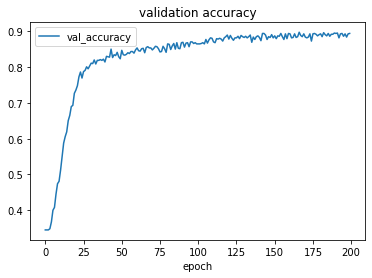

In [218]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [219]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

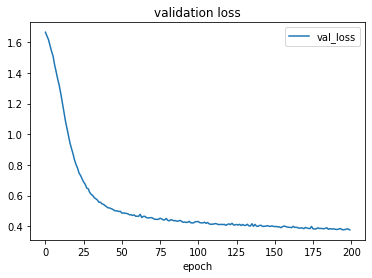

In [220]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

Text(0.5, 0, 'epochs')

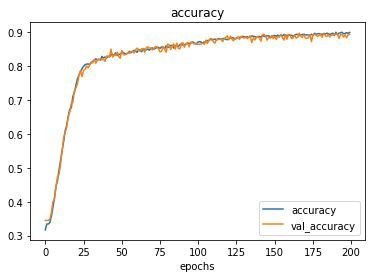

In [221]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')

In [222]:
# individually test for predictions on single point/group of points
point = np.array(data_players_test)
prediction = model.predict_classes(point)
count = 0
total = 0
for i in range(len(data_players_test)):
    if (pos_index_test[i] == prediction[i]):
        count += 1
    total += 1
print(count/total)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index_test)

0.901010101010101
Predicted Classes: [2 2 4 3 2 3 2 0 1 3 1 3 2 1 5 2 4 0 0 2 2 3 3 1 0 2 3 1 3 3 0 2 4 3 1 4 1
 3 2 3 2 3 3 1 3 3 2 0 1 2 3 0 2 5 5 1 2 1 3 0 0 3 3 2 0 4 4 1 4 3 2 3 1 1
 1 2 3 2 3 1 3 2 4 3 3 0 3 0 1 2 0 2 4 4 3 3 1 3 0 5 4 2 2 0 5 1 3 1 1 2 1
 2 3 1 3 2 2 3 5 3 2 2 3 3 4 2 3 3 0 4 1 1 4 1 3 1 0 2 2 4 1 3 2 3 1 2 3 3
 1 1 1 4 1 2 4 3 1 3 3 5 1 3 3 1 3 4 2 1 4 2 2 3 1 4 4 4 2 0 3 2 3 0 0 3 3
 1 3 3 2 5 1 0 4 3 1 1 3 3 2 3 0 4 3 3 2 1 4 3 2 2 3 3 1 2 3 0 1 4 1 3 0 3
 2 4 3 5 3 0 2 1 0 3 2 3 2 4 3 3 2 1 1 0 3 1 4 1 0 3 2 0 3 2 2 3 2 2 3 5 3
 1 5 3 1 4 3 3 3 2 3 3 2 2 2 1 3 3 3 1 3 0 3 1 1 3 1 1 3 2 2 2 2 2 0 3 5 4
 2 0 2 3 3 1 3 2 3 3 3 3 2 2 3 3 4 2 1 4 3 3 3 3 3 4 3 1 4 3 0 3 3 1 3 3 2
 1 3 3 2 3 3 3 3 3 4 2 1 2 4 3 4 3 4 3 1 3 1 1 4 1 0 5 2 5 2 3 0 5 2 2 4 1
 3 4 3 0 1 5 1 3 3 2 1 3 1 4 2 3 4 2 3 1 5 3 3 3 0 3 3 3 3 5 0 3 0 1 2 5 4
 2 3 2 2 2 3 1 3 2 4 4 1 3 5 4 2 2 2 0 2 3 2 4 2 3 3 1 2 1 4 3 0 3 3 4 0 4
 0 4 3 3 3 3 3 3 0 4 3 3 3 1 1 0 3 0 1 3 2 2 2 3 2 3 1 3 4 4 2 

In [204]:
#Again no 4s or 5s